### Study 1:

$$ y_a = (6x-2)^2 sin(12x-4) $$

$$ y_b = 0.5(6x-2)^2 sin(12x-4) + 8(x-0.5) + 5  $$

Case 1: $$ x \sim \mathcal{N}(0.5, 0.5)  $$

Case 2: $$ x \sim \mathcal{B}(5, 0.75) $$

In [50]:
import numpy as np
import matplotlib.pyplot as plt

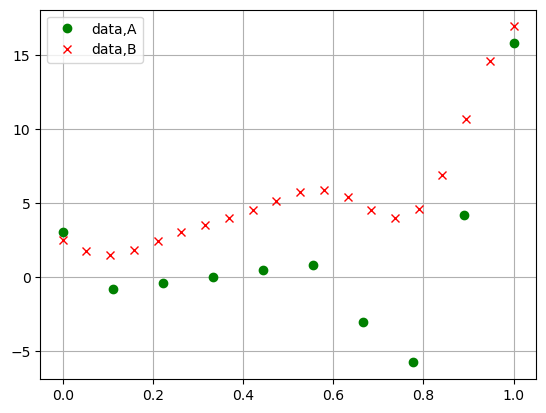

In [51]:
# define the simulator

def sim1a(x):
    return (6*x-2)**2 * np.sin(12*x-4)

def sim1b(x):
    return 0.5*(6*x-2)**2 * np.sin(12*x-4) + 8*(x-0.5) + 5

X1as = np.linspace(0, 1, 10)
X1bs = np.linspace(0, 1, 20)
plt.plot(X1as, [sim1a(xs) for xs in X1as], 'o', color='green', label="data,A")
plt.plot(X1bs, [sim1b(xs) for xs in X1bs], 'x', color='red', label="data,B")
plt.legend()
plt.grid()

In [52]:
sim1a(0.5), sim1b(0.5)

(0.9092974268256817, 5.4546487134128405)

#### Monte Carlo

In [53]:
import time

start_time = time.time()

num_samples = int(1e6)  # number of Monte Carlo samples

random_seed = np.random.randint(0, 100000)
np.random.seed(random_seed)

# Sample from normal distributions based on credible intervals
x1_samples = np.random.normal(0.5, 0.5, num_samples)
#x1_samples = np.random.beta(5, 0.75, num_samples)

# Collect outputs
y1s = []

for i in range(num_samples):
    y1s.append(sim1a(x1_samples[i]))

y1s = np.array(y1s)

end_time = time.time()
print(f"The Monte Carlo simulation had {num_samples} trials and took {(end_time-start_time)/60:.2f} minutes.")
print(f"The random seed used was: {random_seed}")

# Example output: the final concentrations of each species for each Monte Carlo sample
y1s;

The Monte Carlo simulation had 1000000 trials and took 0.02 minutes.
The random seed used was: 85003


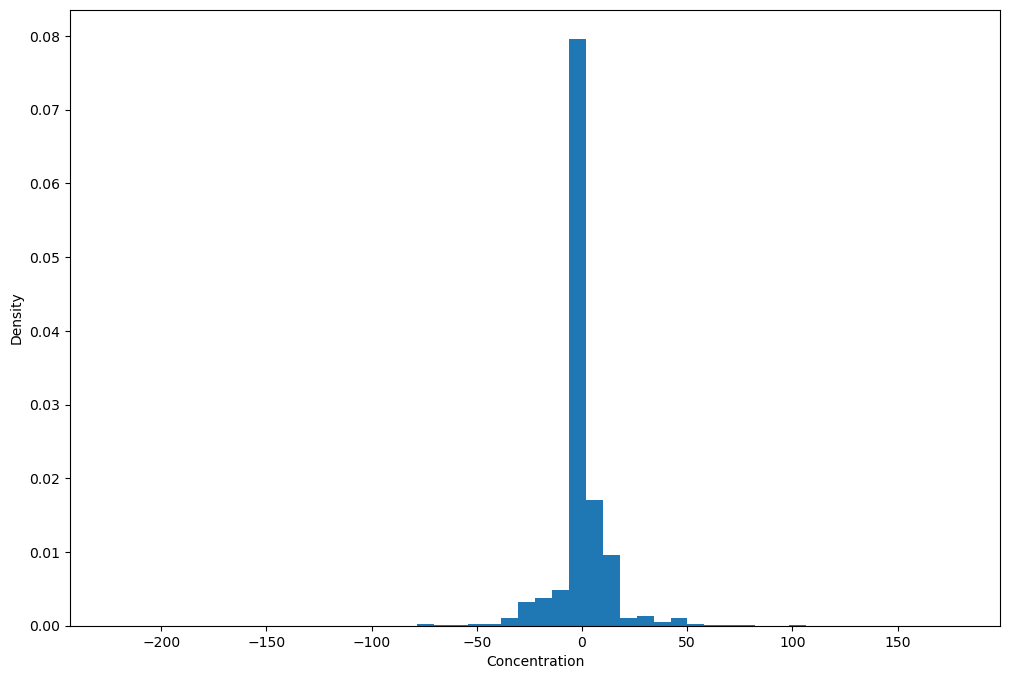

{'mean': 0.011284851548356394,
 'median': 2.4209650666439842e-09,
 'std_dev': 12.205155929123602}

In [54]:
plt.figure(figsize=(12, 8))
plt.hist(y1s, bins=50, density=True)
# plt.title(y1s)
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.show()

# Calculate and print statistical properties
stat_properties = {}

stat_properties["mean"] = np.mean(y1s)
stat_properties["median"] = np.median(y1s)
stat_properties["std_dev"] = np.std(y1s)
stat_properties

### Surrogates with N points

In [55]:
Npoints = 20
X1a = np.linspace(0, 1, Npoints)
Y1a = np.array([sim1a(x1a) for x1a in X1a])

### PCE: My implementation

## Defining the Input Range in Polynomial Chaos Expansion (PCE)

In PCE, the input range plays a crucial role in accurately modeling the uncertain parameters of a system.

- Let $X \in \mathbb{R}$ be a random variable representing an uncertain input parameter.
- We assume that $X$ follows a uniform distribution over some interval, which is often based on the range of available data or expert knowledge about the system.
- In mathematical terms, if $a$ and $b$ are the minimum and maximum of the observed data (e.g., `X1a`), then $X \sim \mathcal{U}(a, b)$, where $\mathcal{U}(a, b)$ denotes the uniform distribution over the interval $[a, b]$.

In [56]:
def uniform_weight_function(a, b):
    """
    generates a weight function corresponding to a uniform distribution over a specified interval `[a, b]`.
    """

    def weight(x):
        # Check if x is within the interval [a, b]
        if a <= x <= b:
            return 1.0 / (b - a)
        else:
            return 0
    return weight


## Definition and Properties of Legendre Polynomials

### Orthogonality
Legendre polynomials $ P_n(x) $ exhibit a key property of orthogonality over the interval \([-1, 1]\) with respect to the weight function \( $w(x)$ = 1 \). This is mathematically represented as:
$$ \int_{-1}^{1} P_m(x) P_n(x) \, dx = 0 \quad \text{for} \quad m \neq n $$

### Standard Interval
The polynomials are defined over the interval \([-1, 1]\), meaning that for any \( x \) within this interval, the Legendre polynomials are well-defined.

### Recurrence Relation
Legendre polynomials can be generated using a recurrence relation, which is a common method for computational purposes. The first few polynomials are $P_0(x)=1$, $P_1(x)=x$, and higher-degree polynomials can be generated using:

$$ (n+1)P_{n+1}(x) = (2n+1)x  P_n(x) - n P_{n-1}(x) $$

### Normalization
These polynomials are typically normalized such that $P_n(1)=1 \quad \forall n$.


In [57]:
from scipy.special import legendre

def rescale_legendre_poly(poly, a=-1, b=1):
    """
    Rescales a Legendre polynomial from [-1, 1] to [a, b].

    Args:
    poly (function): polynomial basis
    a (float): Lower bound of the new interval.
    b (float): Upper bound of the new interval.

    Returns:
    function: A new polynomial function rescaled to [a, b].
    """
    def rescaled_poly(x):
        # Rescale x from [a, b] to [-1, 1]
        t = (2*x - a - b) / (b - a)
        return poly(t)

    return np.vectorize(rescaled_poly)

# Create an orthogonal polynomial basis
degree = 5  # Degree of the polynomial
a, b = min(X1a), max(X1a)
polynomials = [rescale_legendre_poly(legendre(i)) for i in range(degree + 1)]

for degree, poly in enumerate(polynomials):
    print(f"Degree {degree} polynomial: {poly}")

Degree 0 polynomial: <numpy.vectorize object at 0x00000182BE998370>
Degree 1 polynomial: <numpy.vectorize object at 0x00000182BF177430>
Degree 2 polynomial: <numpy.vectorize object at 0x00000182BF635E80>
Degree 3 polynomial: <numpy.vectorize object at 0x00000182BF635610>
Degree 4 polynomial: <numpy.vectorize object at 0x00000182BF15BA00>
Degree 5 polynomial: <numpy.vectorize object at 0x00000182BF15B2E0>


In [58]:
from numpy.linalg import lstsq

# Create the design matrix
X_design = np.vstack([p(X1a) for p in polynomials]).T

# Perform the least squares regression to find the coefficients
coefficients, _, _, _ = lstsq(X_design, Y1a, rcond=None)

# The pce_model is essentially the coefficients and the polynomials
pce_model = {"coefficients": coefficients, "polynomials": polynomials}

print("PCE Model Coefficients:", coefficients)

PCE Model Coefficients: [ 368.60504936 -871.94127504  890.24701641 -555.31882811  213.65652598
  -27.40823065]


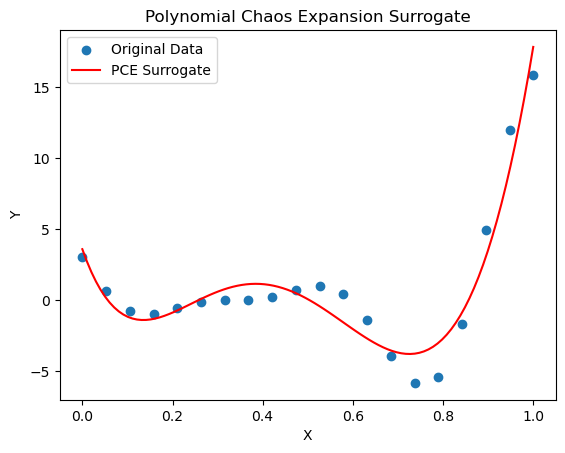

In [59]:
# Generate a fine grid for plotting
x_grid = np.linspace(min(X1a), max(X1a), 100)

# Predict with the PCE model
y_predicted = sum(coef * poly(x_grid) for coef, poly in zip(pce_model['coefficients'], pce_model['polynomials']))

# Plotting the original data and the PCE surrogate
plt.scatter(X1a, Y1a, label='Original Data')
plt.plot(x_grid, y_predicted, label='PCE Surrogate', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polynomial Chaos Expansion Surrogate')
plt.legend()
plt.show()

## Chaospy  implementaion

In [60]:
import chaospy as cp

In [61]:
# Define the range of the input
q = cp.Uniform(min(X1a), max(X1a))

# Create an orthogonal polynomial basis
degree = 5  # Degree of the polynomial
polynomials = cp.orth_ttr(degree, q)

# Fit the PCE model to the data
pce_model_cp = cp.fit_regression(polynomials, X1a, Y1a)

# Generate a fine grid for plotting
x_grid = np.linspace(min(X1a), max(X1a), 100)
y_chaospy = pce_model_cp(x_grid)

y_predicted_pce = sum(coef * poly(x_grid) for coef, poly in zip(pce_model['coefficients'], pce_model['polynomials']))

mean = cp.E(pce_model_cp, q)
variance = cp.Var(pce_model_cp, q)

### Gpy implementation of Gaussian Process Regression

In [62]:
import GPy

# Define the kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Create the GP model
gp_model = GPy.models.GPRegression(X1a.reshape(-1, 1), Y1a.reshape(-1, 1), kernel)

# Optimize the model (find the best hyperparameters)
gp_model.optimize(messages=True)

# Print the optimized model's parameter values
print(gp_model)
y_gp_pred, _ = gp_model.predict(x_grid.reshape(-1, 1))


Name : GP regression
Objective : -21.121375723907157
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       1819.812726742276  |      +ve      |        
  rbf.lengthscale          |     0.23671848802205253  |      +ve      |        
  Gaussian_noise.variance  |  3.159582795110313e-203  |      +ve      |        


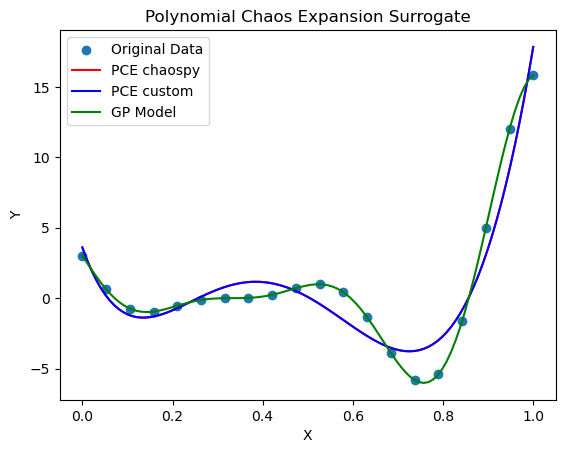

In [63]:
# Plotting the original data and the PCE surrogate
plt.scatter(X1a, Y1a, label='Original Data')
plt.plot(x_grid, y_chaospy, label='PCE chaospy', color='red')
plt.plot(x_grid, y_predicted_pce, label='PCE custom', color='blue')
plt.plot(x_grid, y_gp_pred, label='GP Model', color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polynomial Chaos Expansion Surrogate')
plt.legend()
plt.show()